
## <center> Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Александр Ничипоренко

## <center> Индивидуальный проект по анализу данных </center>

Данные лежат здесь: https://yadi.sk/d/mJbzt5pV3Uf5Zt

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,f1_score,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier as lgbmc
from catboost import CatBoostClassifier as catc
from xgboost import XGBClassifier as xgbc
plt.rcParams['figure.figsize'] = (20,20)
sns.set(style="darkgrid");
%matplotlib inline

###  Часть 1. Описание набора данных и признаков.

Одной из главных целей для любой компании является удержание своих клиентов. В торговле успехом данного процесса является совершение повторных покупок клиентами в интервал времени, который характеризует потребление различных видов товаров:

- Продукты: каждый день - еженедельно;
- Хозтовары: каждые 2 недели - месяц;
- Одежда: раз в три месяца - раз в полгода;
- Крупная и дорогая электроника: раз в 1-2 года;
- Автомобиль: раз в 3-5 лет.

В данном проекте будут исследованы данные одного заказчика (менеджеров крупного интернет-гипермаркета, основным ассортиментом которого являются товары повседневного спроса) и построена модель, предсказывающая вероятность оттока клиента.

Заказчик определил отток таким образом: клиент не сделает повторный заказ в течение трёх месяцев.
Такая постановка обусловлена тем, что почти 80% клиентов делают свой повторный заказ в течение 3-х месяцев. Таким образом поставлена цель научиться определять 20% клиентов, которые этого не сделают. 

После этого, уже можно разрабатывать различные подходы к стимулированию данного пула клиентов к повторной сделке с помощью различных маркетинговых методов.

Данные были получены от заказчика и сведены в один DataFrame. Посмотрим на них.



In [59]:
df = pd.read_csv('data.csv',index_col='Client')

In [3]:
df.head(10)

,Y_M,R_1,R_2,R_3,R_4,R_5,R_6,R_NOW,target,S_1,...,Revenue-7203,Revenue-7204,Revenue-7205,Revenue-7206,Revenue-7208,Revenue-7209,Revenue-820,Revenue-901,Revenue-931,Revenue-Other
Client,,,,,,,,,,,,,,,,,,,,,
1000786,2016_07,5550,1712,5550,0,5550,0,26591,0,1,...,293,0,0,0,0,1863,0,0,0,2213
1001074,2016_07,0,10518,11624,0,0,0,6229,0,0,...,0,0,57,212,0,347,0,0,0,5386
1001493,2016_07,6562,0,8236,0,5096,0,5396,1,13,...,0,0,0,0,0,0,0,0,0,2836
1001643,2016_07,0,4878,7106,5987,6990,8176,8005,0,0,...,64,0,0,76,0,527,0,0,0,1622
1001901,2016_07,0,0,16854,0,0,0,31623,1,0,...,360,80,16,1883,864,1754,0,122,0,1864
1002150,2016_07,15293,6134,13933,14702,0,14232,12908,0,19,...,0,0,0,570,0,2208,0,0,0,5774
1002536,2016_07,0,5893,0,0,0,0,8997,0,0,...,0,0,0,2343,0,463,0,0,0,0
1002820,2016_07,10976,0,9633,12835,4732,0,10257,0,8,...,0,0,0,0,0,0,0,0,0,0
1002940,2016_07,14560,0,0,14909,0,0,3701,1,10,...,157,0,0,0,0,0,0,0,0,272


In [4]:
df.shape

(233978, 273)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233978 entries, 1000786 to 99976
Columns: 273 entries, Y_M to Revenue-Other
dtypes: int64(272), object(1)
memory usage: 489.1+ MB


In [6]:
for index,value in enumerate(df.columns):
    print (index,":",value)

0 : Y_M
1 : R_1
2 : R_2
3 : R_3
4 : R_4
5 : R_5
6 : R_6
7 : R_NOW
8 : target
9 : S_1
10 : S_2
11 : S_3
12 : S_4
13 : S_5
14 : S_6
15 : S_NOW
16 : O_1
17 : O_2
18 : O_3
19 : O_4
20 : O_5
21 : O_6
22 : O_NOW
23 : Q_1
24 : Q_2
25 : Q_3
26 : Q_4
27 : Q_5
28 : Q_6
29 : Q_NOW
30 : Month
31 : R_N_1
32 : R_N_2
33 : R_N_3
34 : R_N_4
35 : R_N_5
36 : R_N_6
37 : R_N_NOW
38 : R_Y_1
39 : R_Y_2
40 : R_Y_3
41 : R_Y_4
42 : R_Y_5
43 : R_Y_6
44 : R_Y_NOW
45 : O_N_1
46 : O_N_2
47 : O_N_3
48 : O_N_4
49 : O_N_5
50 : O_N_6
51 : O_N_NOW
52 : O_Y_1
53 : O_Y_2
54 : O_Y_3
55 : O_Y_4
56 : O_Y_5
57 : O_Y_6
58 : O_Y_NOW
59 : Other
60 : Orders-1003
61 : Orders-1005
62 : Orders-1006
63 : Orders-1010
64 : Orders-1013
65 : Orders-1015
66 : Orders-1016
67 : Orders-1017
68 : Orders-1018
69 : Orders-1019
70 : Orders-1024
71 : Orders-1025
72 : Orders-1102
73 : Orders-1103
74 : Orders-1105
75 : Orders-1108
76 : Orders-1116
77 : Orders-1117
78 : Orders-1119
79 : Orders-1402
80 : Orders-1405
81 : Orders-1406
82 : Orders-1407


Как видно у нас **273** столбца, целевая переменная - **target**, 271 - количественный и 1 категориальный признак("Y M" = "Год Месяц").
Каждая строка - описание клиента (история его покупок за текущий и предыдущие 6 месяцев) в месяц последней покупки.

#### Теперь о количественных признаках.

###### Сокращения:
- **R** - Revenue - Выручка от продажи;
- **S** - Strings - Кол-во строк - разных позиций (артикулов);
- **O** - Orders - Кол-во заказов;
- **Q** - Qnt - Кол-во штук;

- **R_1 ... R_6, R_NOW**- Выручка по месяцам. NOW - месяц, соответствующий Y_M, _6 - предыдущий, _1 - 6 месяцев назад.
- **Month**: от 1 до 12 (январь-декабрь).
- **Y** или **N** в **R_Y_NOW, O_Y_NOW, R_N_NOW, R_N_NOW** - выручка/заказы в зависимости от способа оформления заказа. **Y** - через сайт, **N** - по телефону.

- **Orders-1003 ... Orders-Other** - заказы за 7 месяцев (от _1 до _NOW) по выделенной группе товаров (70 "топовых" групп: 1003, ..., 931) или по остальным (Other). Аналогично и с выручкой и кол-ву штук.

- **Other** - Кол-во групп товаров, купленных за 7 месяцев, входящих в группу "Other".

###  Часть 2. Первичный анализ признаков

Посмотрим количество пропусков в данных. Как видно их нет.

In [7]:
sum(df.isnull().sum())

0

Посмотрим среднее количество "отточных клиентов" в наборе данных.

In [8]:
print ('% клиентов, склонных к оттоку:', round(df['target'].mean()*100,2))

% клиентов, склонных к оттоку: 15.61


Получается даже меньше 20%. Выборка не сбалансирована.

##### Посмотрим сколько у нас "отточных" клиентов ежемесячно.

In [9]:
churn=pd.crosstab(index=df['Y_M'],columns=df['target'])
churn['%']=round(churn[1]/churn[0]*100,2)

In [10]:
churn.T

Y_M,2016_07,2016_08,2016_09,2016_10,2016_11,2016_12,2017_01,2017_02,2017_03,2017_04,2017_05,2017_06,2017_07,2017_08,2017_09,2017_10,2017_11,2017_12
target,,,,,,,,,,,,,,,,,,
0,10079.00,10578.0,11315.0,11336.00,11552.00,11231.00,10516.0,10556.00,11875.00,10961.00,10453.00,10673.00,10431.00,11039.00,11378.00,11441.00,11343.00,10687.00
1,1762.00,1693.0,1912.0,2082.00,2219.00,2294.00,1967.0,2095.00,2038.00,2252.00,2086.00,1983.00,1756.00,1651.00,2058.00,2065.00,2329.00,2292.00
%,17.48,16.0,16.9,18.37,19.21,20.43,18.7,19.85,17.16,20.55,19.96,18.58,16.83,14.96,18.09,18.05,20.53,21.45


In [11]:
churn_m=pd.crosstab(index=df['Month'],columns=df['target'])
churn_m['%']=round(churn_m[1]/churn_m[0]*100,2)

In [12]:
churn_m.T

Month,1,2,3,4,5,6,7,8,9,10,11,12
target,,,,,,,,,,,,
0,10516.0,10556.00,11875.00,10961.00,10453.00,10673.00,20510.00,21617.00,22693.00,22777.00,22895.00,21918.00
1,1967.0,2095.00,2038.00,2252.00,2086.00,1983.00,3518.00,3344.00,3970.00,4147.00,4548.00,4586.00
%,18.7,19.85,17.16,20.55,19.96,18.58,17.15,15.47,17.49,18.21,19.86,20.92


Видна некоторая сезонность, в конце года "отточных" клиентов больше, летом - меньше. Осенью клиенты делают закупки активнее.

###### Числовых показателей у нас много. Будем рассматривать их небольшими группами.
Для начала посмотрим на статистичекское описание ежемесячных показателей.

In [13]:
df.drop(columns=['target','Month']).iloc[:,:29].describe().T

,count,mean,std,min,25%,50%,75%,max
R_1,233978.0,5972.258264,16097.967518,-65113.0,0.0,2638.5,8104.00,1499055.0
R_2,233978.0,6064.049240,16049.428957,-75733.0,0.0,3011.0,8216.00,1499055.0
R_3,233978.0,6161.734616,16252.290763,-56276.0,0.0,3049.0,8332.00,1499055.0
R_4,233978.0,6272.829946,16112.360566,-120698.0,0.0,3098.0,8442.75,1499055.0
R_5,233978.0,6339.415804,15610.967147,-120698.0,0.0,3130.0,8547.00,1499055.0
R_6,233978.0,5854.222906,15743.445868,-120698.0,0.0,1090.0,7771.75,1499055.0
R_NOW,233978.0,10320.910376,16095.674203,1.0,3943.0,7016.0,12219.00,1499055.0
S_1,233978.0,9.160895,15.872037,0.0,0.0,3.0,14.00,1001.0
S_2,233978.0,9.266803,15.729310,0.0,0.0,3.0,14.00,1038.0
S_3,233978.0,9.439016,15.919296,0.0,0.0,4.0,15.00,1053.0


###### Можно заметить, что:

- Масштабы признаков сильно различаются (наиболее сильно: выручка и заказы);
- Есть отрицательные значения - это возвраты;
- Статистики по предыдущим периодам сильно скошены (среднее больше медианы) из-за того, что много нулей и величины распределены не нормально;
- Максимальные значения - очень сильно отличаются от средних, кто-то покупает покупает много товаров или дорогие товары;
- Обычно клиенты делают один заказ в течение месяца;
- В предыдущий месяц (_6) клиенты заказывают меньше, чем в другие предыдущие.

##### Посмотрим на значения показателей (выручка, заказы) по способу оформления заказа.

In [14]:
df.drop(columns=['target','Month']).iloc[:,29:29+14*2].describe().T

,count,mean,std,min,25%,50%,75%,max
R_N_1,233978.0,1208.706109,11900.254661,-175700.0,0.0,0.0,0.0,1457027.0
R_N_2,233978.0,1191.856884,11603.218853,-175700.0,0.0,0.0,0.0,1457027.0
R_N_3,233978.0,1180.268012,11767.172429,-175700.0,0.0,0.0,0.0,1457027.0
R_N_4,233978.0,1153.415731,11327.877526,-128321.0,0.0,0.0,0.0,1457027.0
R_N_5,233978.0,1114.314636,10533.000426,-128321.0,0.0,0.0,0.0,1457027.0
R_N_6,233978.0,1023.511381,10517.408834,-128321.0,0.0,0.0,0.0,1457027.0
R_N_NOW,233978.0,1620.154921,10619.056692,-22000.0,0.0,0.0,0.0,1457027.0
R_Y_1,233978.0,4763.552796,10235.108348,-72598.0,0.0,0.0,6821.0,848409.0
R_Y_2,233978.0,4872.192967,10380.000519,-55053.0,0.0,0.0,6960.0,848409.0
R_Y_3,233978.0,4981.467117,10508.100535,-64778.0,0.0,0.0,7108.0,848409.0


Заметно, что преобладают заказы, оформленные через Интернет.

#### Посмотрим разницу по показателям в зависимости от целевого признака.

In [15]:
ch_1=df[df['target']==1].drop(columns=['target','Month']).iloc[:,:29].describe().T

In [16]:
ch_0=df[df['target']==0].drop(columns=['target','Month']).iloc[:,:29].describe().T

In [17]:
ch_0-ch_1

,count,mean,std,min,25%,50%,75%,max
R_1,160910.0,3843.463121,6596.338308,-39377.0,0.0,3406.0,5874.25,649688.0
R_2,160910.0,3948.406797,6402.018343,-63792.0,0.0,3537.0,5990.00,511712.0
R_3,160910.0,4135.560078,7125.044127,-36650.0,0.0,3677.0,6412.25,572034.0
R_4,160910.0,4535.338259,8203.520036,64422.0,0.0,3848.0,7821.75,703795.0
R_5,160910.0,4993.734173,8749.785598,-67098.0,0.0,4001.5,9454.00,862048.0
R_6,160910.0,4929.276789,7579.728198,-106542.0,0.0,3194.0,8774.25,511712.0
R_NOW,160910.0,1671.197232,6025.410130,-12.0,572.0,1134.0,1714.25,855605.0
S_1,160910.0,6.226579,5.846908,0.0,0.0,5.0,13.00,346.0
S_2,160910.0,6.306736,6.290103,0.0,0.0,5.0,13.00,421.0
S_3,160910.0,6.557101,5.093705,0.0,0.0,6.0,13.00,-15.0


Как видно, клиенты, которые нас интересуют - покупают меньше. В особенности, в предыдущие периоды.

##### Посмотрим, какие товары заказывают и на какие товары тратят деньги наши клиенты.

In [18]:
goods=pd.pivot_table(data=df,values=df.iloc[:,202:273],columns=df['target'],aggfunc=np.sum)
goods['%_churn']=goods[1]/goods[0]*100
goods.sort_values(by='%_churn',ascending=False).head(10)

target,0,1,%_churn
Revenue-1505,173284376,21401846,12.350707
Revenue-4101,14678554,1803455,12.286326
Revenue-1502,642009645,78740082,12.264626
Revenue-1827,4952293,574241,11.595457
Revenue-1102,43017404,4723630,10.980742
Revenue-7201,8561431,906990,10.593907
Revenue-7204,4716890,492497,10.441138
Revenue-7208,13144828,1371746,10.435633
Revenue-1830,34087823,3504975,10.282191
Revenue-1103,51939225,5200266,10.012213


Как видно, по разным категориям товаров доля затраченных денег отличается. Таким образом, если клиент потратил сумму на какую-то группу товаров, то вероятность его ухода как понижается, так и повышается в зависимости от этой группы.

In [19]:
goods_ord=pd.pivot_table(data=df,values=df.iloc[:,60:131],columns=df['target'],aggfunc=np.sum)
goods_ord['%_churn']=goods_ord[1]/goods_ord[0]*100
goods_ord.sort_values(by='%_churn',ascending=False).head(10)

target,0,1,%_churn
Orders-4101,37785,4601,12.176790
Orders-1502,130715,15362,11.752286
Orders-1505,45767,5251,11.473332
Orders-1827,22617,2393,10.580537
Orders-1102,45205,4725,10.452384
Orders-1005,158649,15990,10.078853
Orders-1826,30783,3064,9.953546
Orders-7204,64748,6235,9.629641
Orders-5308,107272,10015,9.336080
Orders-3602,730,68,9.315068


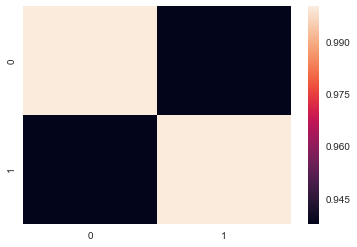

In [20]:
sns.heatmap(np.corrcoef(goods_ord['%_churn'],goods['%_churn']));

Как видно, заказы и деньги по товарным категориям коррелируют.

###### Посмотрим, сколько товарных групп из "Other" покупают разные клиенты.

In [21]:
Other_0=df[df['target']==0]['Other'].describe()
Other_1=df[df['target']==1]['Other'].describe()
Other=pd.concat([Other_0,Other_1],axis=1,names=['Total','1'])
Other.columns=['0','1']
Other

,0,1
count,197444.000000,36534.000000
mean,3.332616,1.593858
std,3.634617,2.190686
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,5.000000,2.000000
max,85.000000,43.000000


Как видно, уходящие клиенты покупают обычно в два раза меньше товаров из категории "Другое".

###  Часть 3. Первичный визуальный анализ признаков

Визуализируем распределение целевого класса.

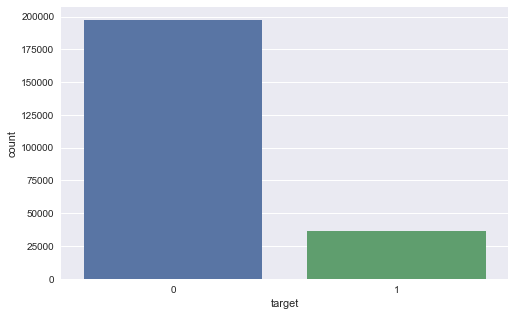

In [22]:
plt.figure(figsize=[8, 5])
sns.countplot(df['target']);

Далее будем исследовать распределения признаков в зависимости от значения **"target"**. Для скошенных влево распределений будем применять **log(1+x)** преобразование и отсекать экстремально большие значения (>95%-99% квантили).

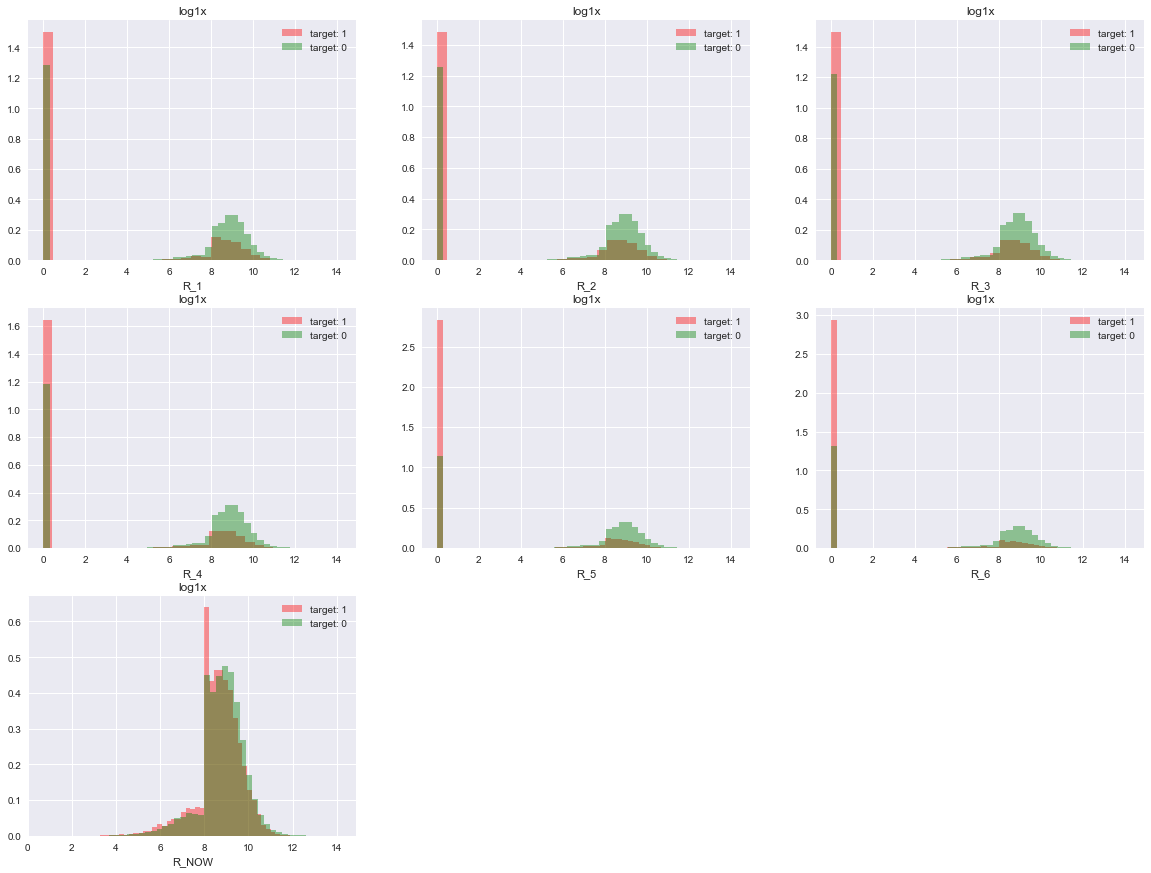

In [23]:
plt.figure(figsize=[20, 15])
for i in range(1,8):
    plt.subplot(3, 3, i)
    sns.distplot(np.log1p(df[df['target']==1].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(np.log1p(df[df['target']==0].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('log1x')

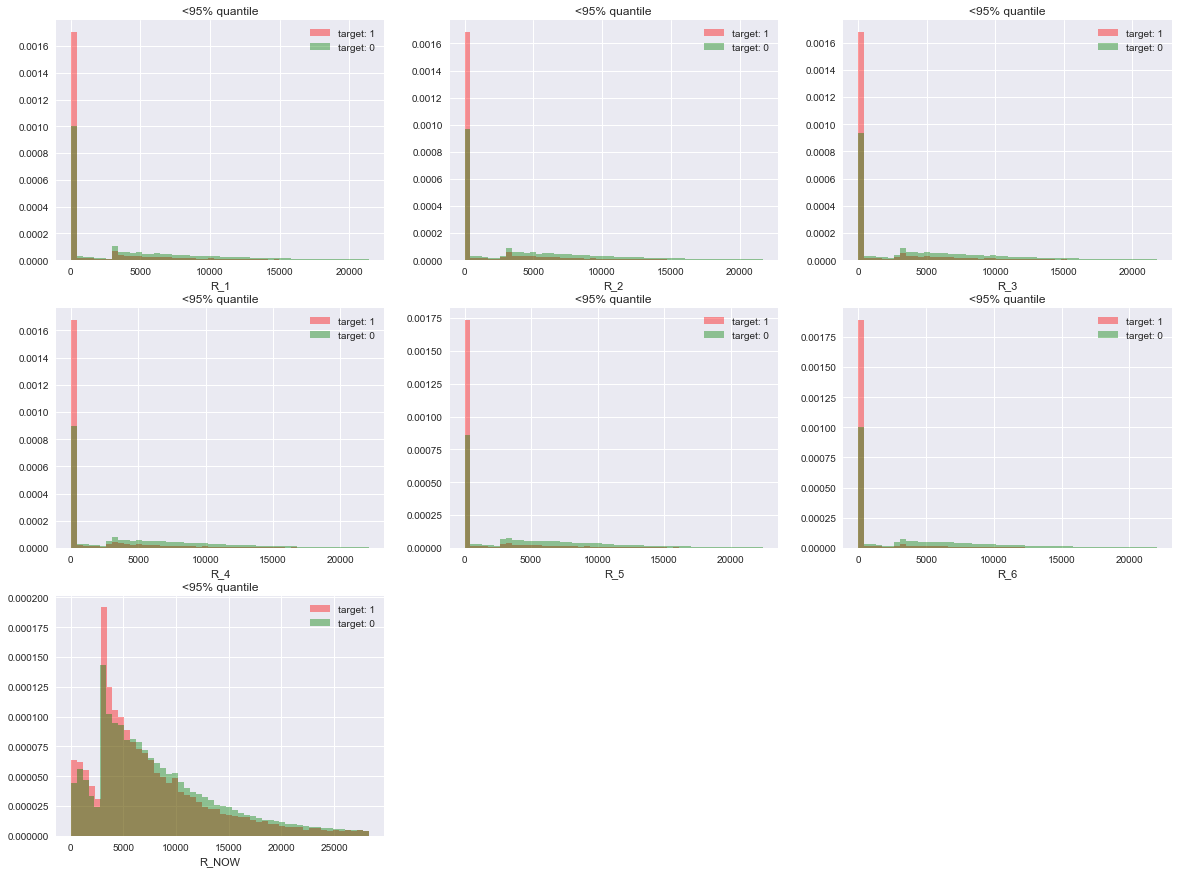

In [24]:
plt.figure(figsize=[20, 15])
for i in range(1,8):
    plt.subplot(3, 3, i)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<95% quantile')

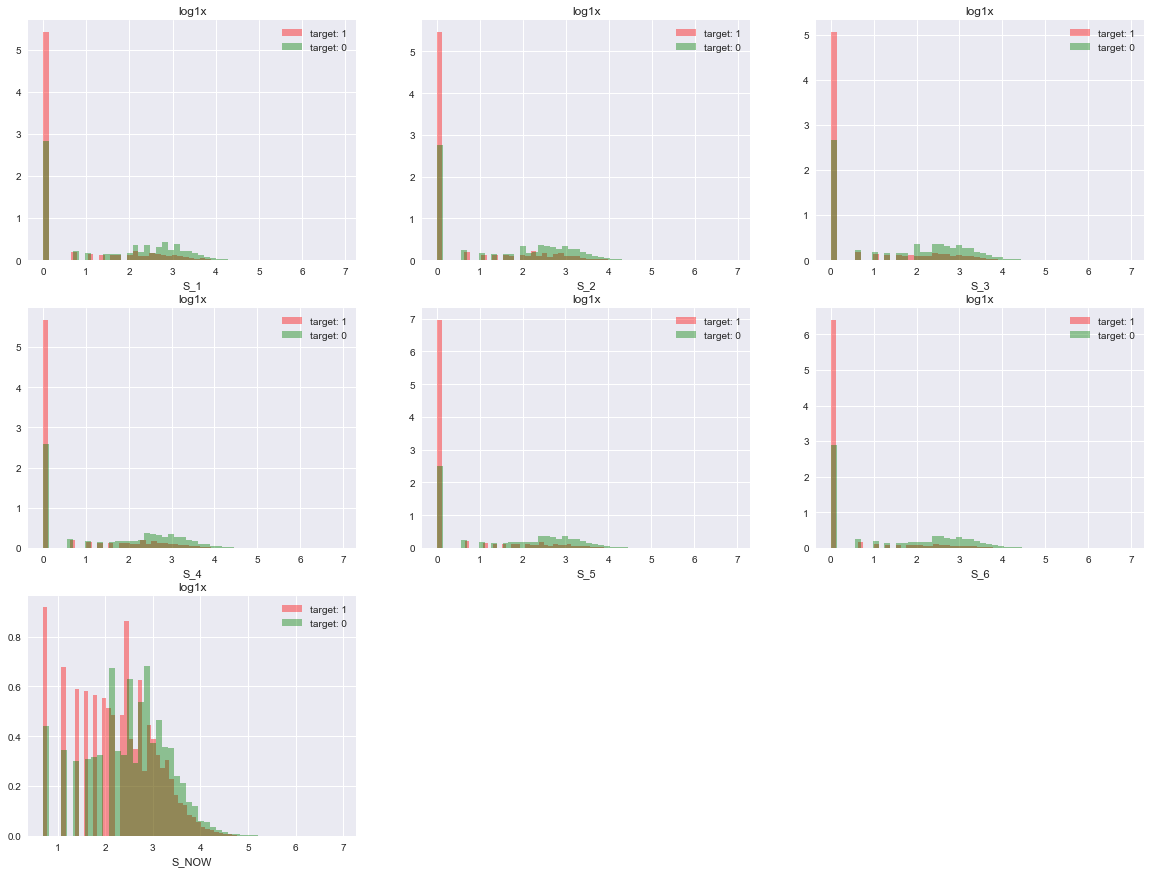

In [25]:
plt.figure(figsize=[20, 15])
for i in range(1+8,8+8):
    plt.subplot(3, 3, i-8)
    sns.distplot(np.log1p(df[df['target']==1].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(np.log1p(df[df['target']==0].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('log1x')

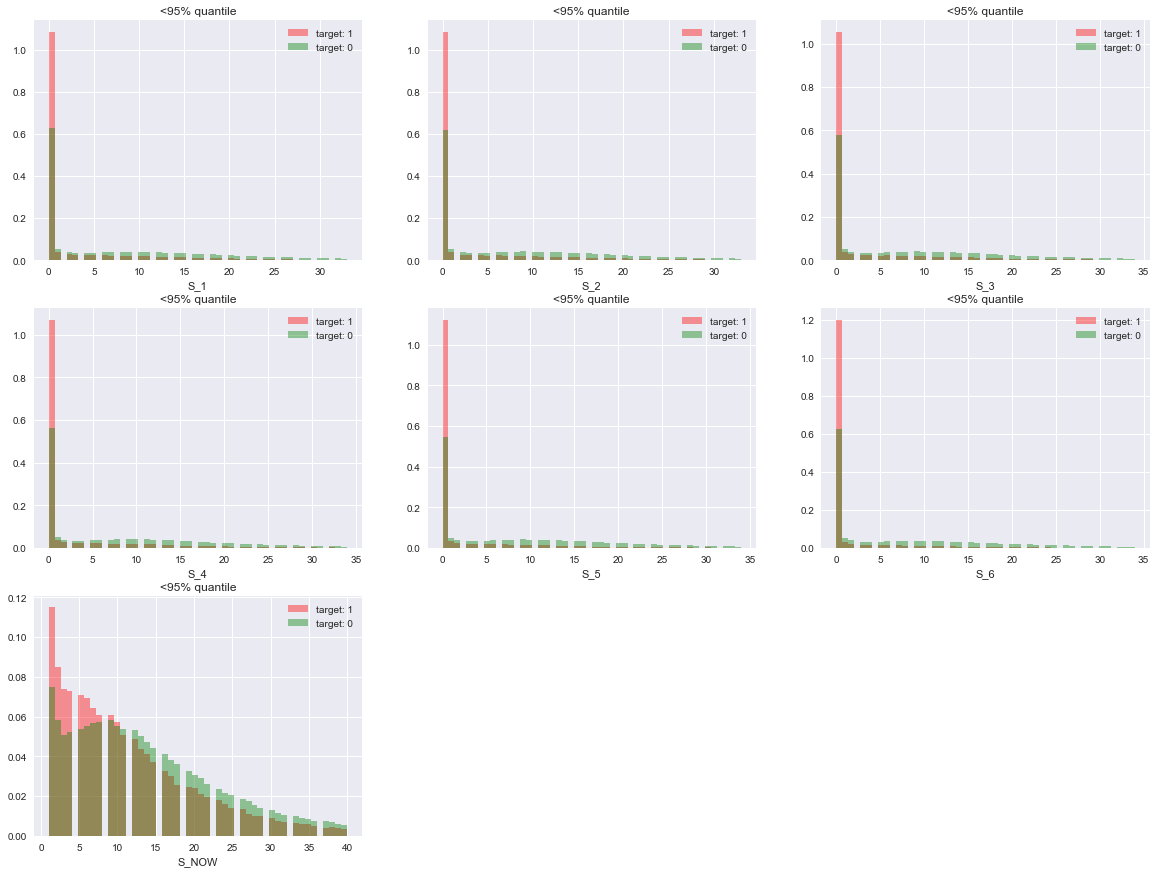

In [26]:
plt.figure(figsize=[20, 15])
for i in range(1+8,8+8):
    plt.subplot(3, 3, i-8)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i],kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i],kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<95% quantile')

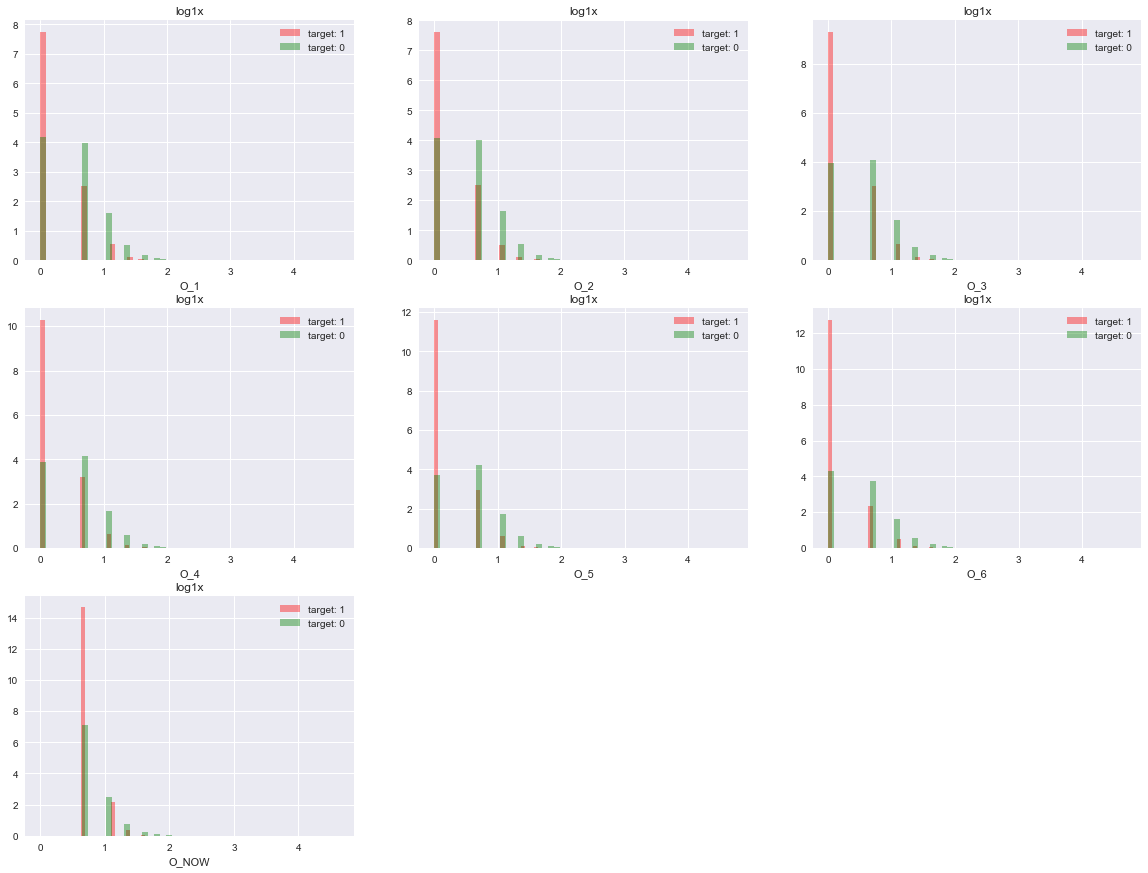

In [27]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7,8+8+7):
    plt.subplot(3, 3, i-8-7)
    sns.distplot(np.log1p(df[df['target']==1].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(np.log1p(df[df['target']==0].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('log1x')

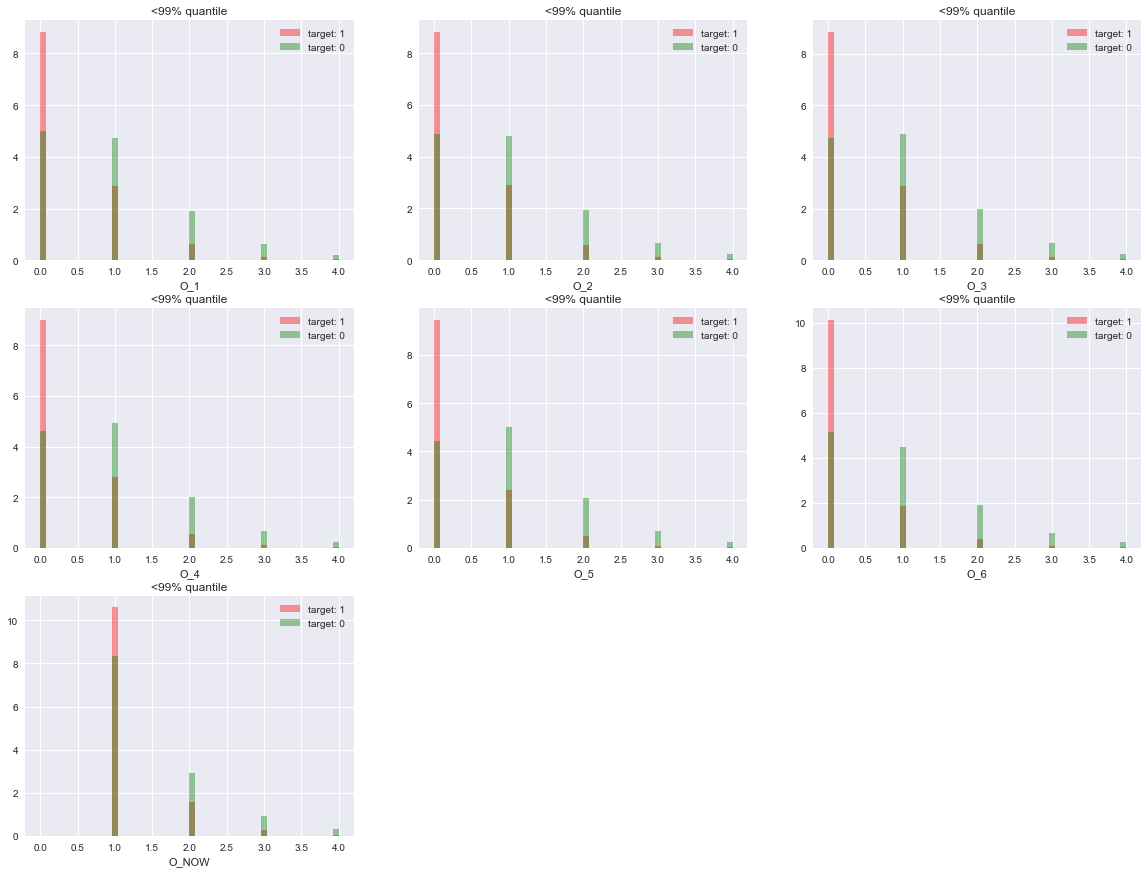

In [28]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7,8+8+7):
    plt.subplot(3, 3, i-8-7)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.99))].iloc[:,i],kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.99))].iloc[:,i],kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<99% quantile')

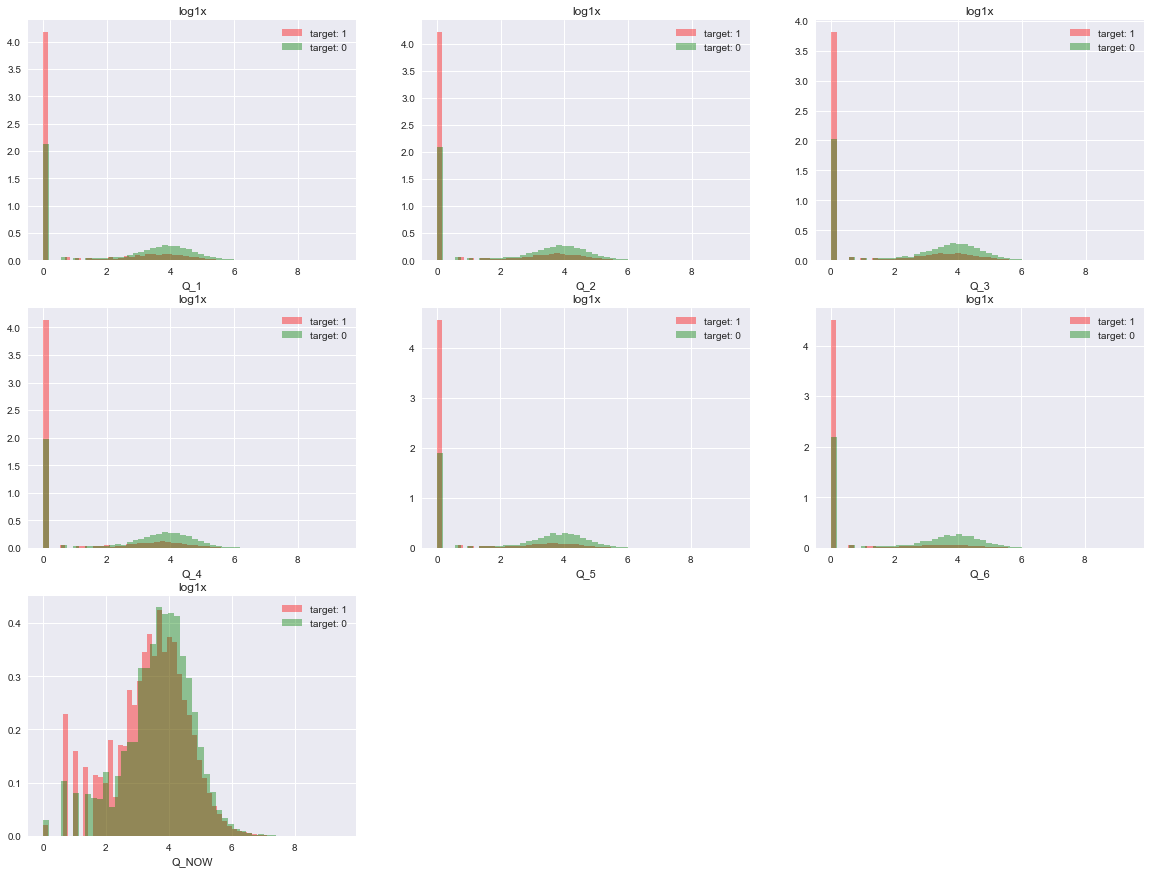

In [29]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7+7,8+8+7+7):
    plt.subplot(3, 3, i-8-7-7)
    sns.distplot(np.log1p(df[df['target']==1].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(np.log1p(df[df['target']==0].iloc[:,i].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('log1x')

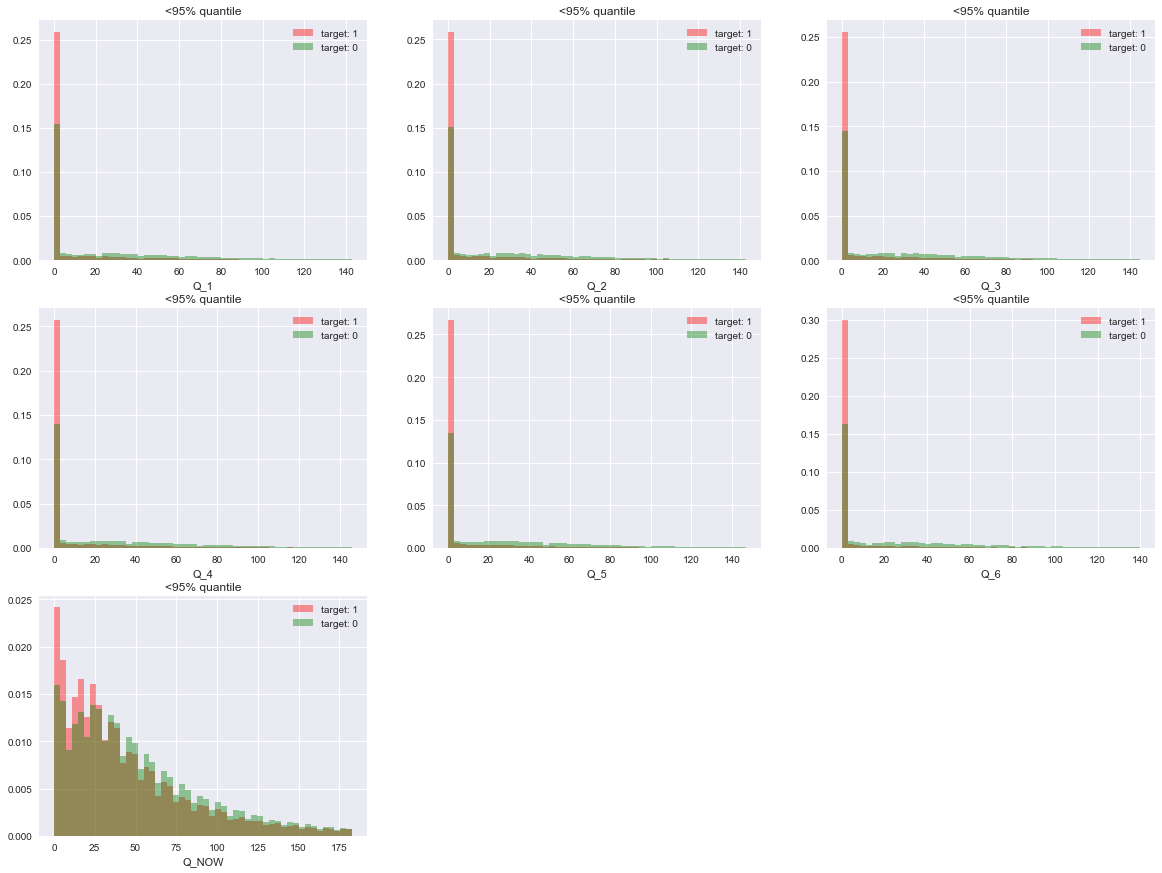

In [30]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7+7,8+8+7+7):
    plt.subplot(3, 3, i-8-7-7)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<95% quantile')

**По распределениям показателей за месяца можно увидеть, что:**
- В месяц "NOW" у "отточных" клиентов сумма отгрузки, кол-во артикулов, штук и заказов меньше;
- В месяц "NOW" у "отточных" клиентов пик на уровне 4000;
- В предыдущие месяца у "отточных клиентов" меньше заказов и они реже;

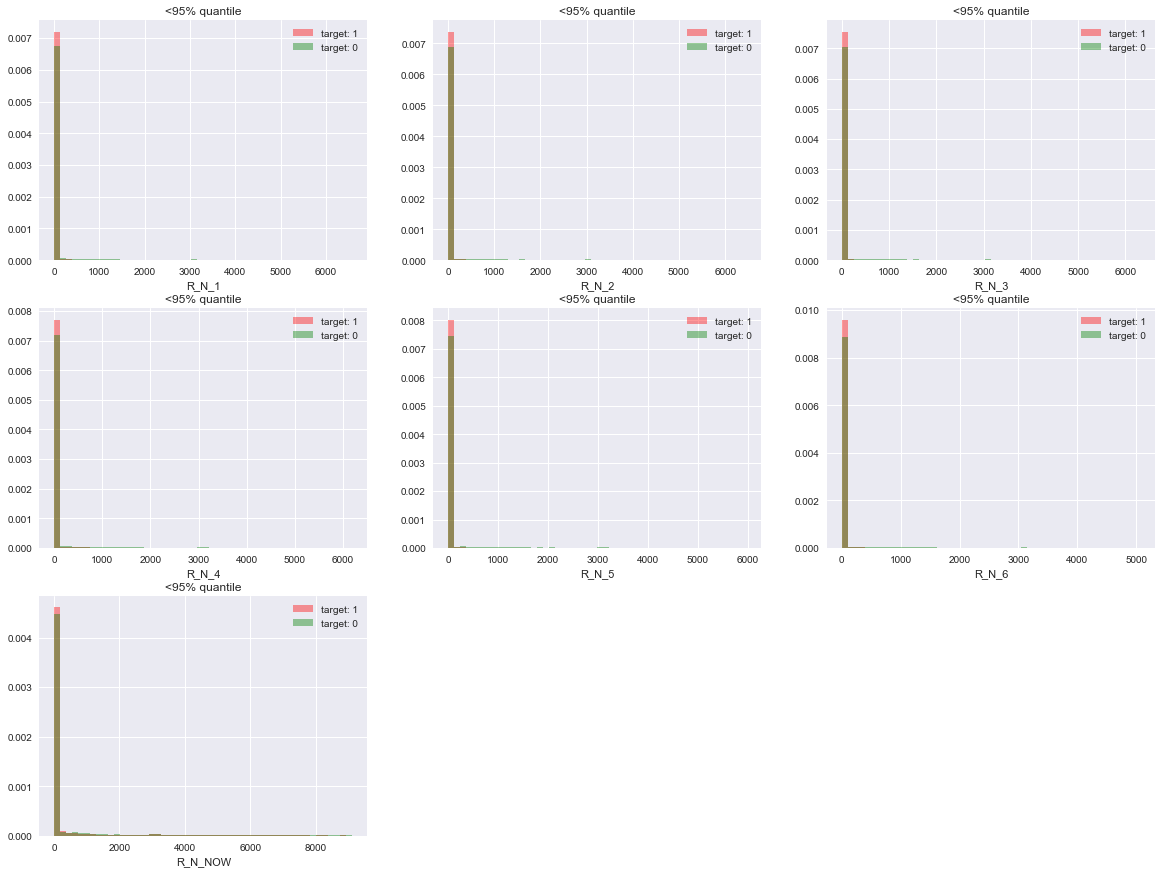

In [31]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7+7+8,8+8+7+7+8):
    plt.subplot(3, 3, i-8-7-7-8)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<95% quantile')

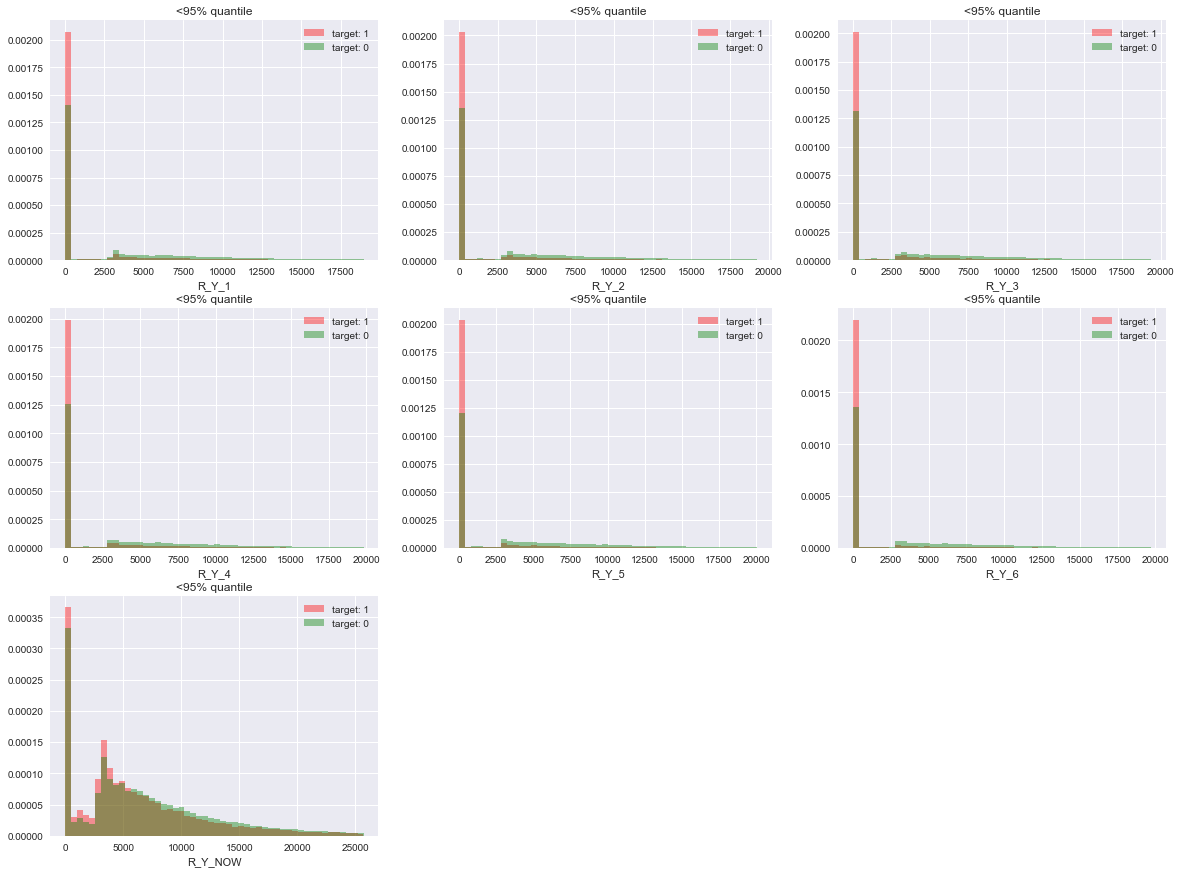

In [32]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7+7+8+7,8+8+7+7+8+7):
    plt.subplot(3, 3, i-8-7-7-8-7)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.95))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<95% quantile')

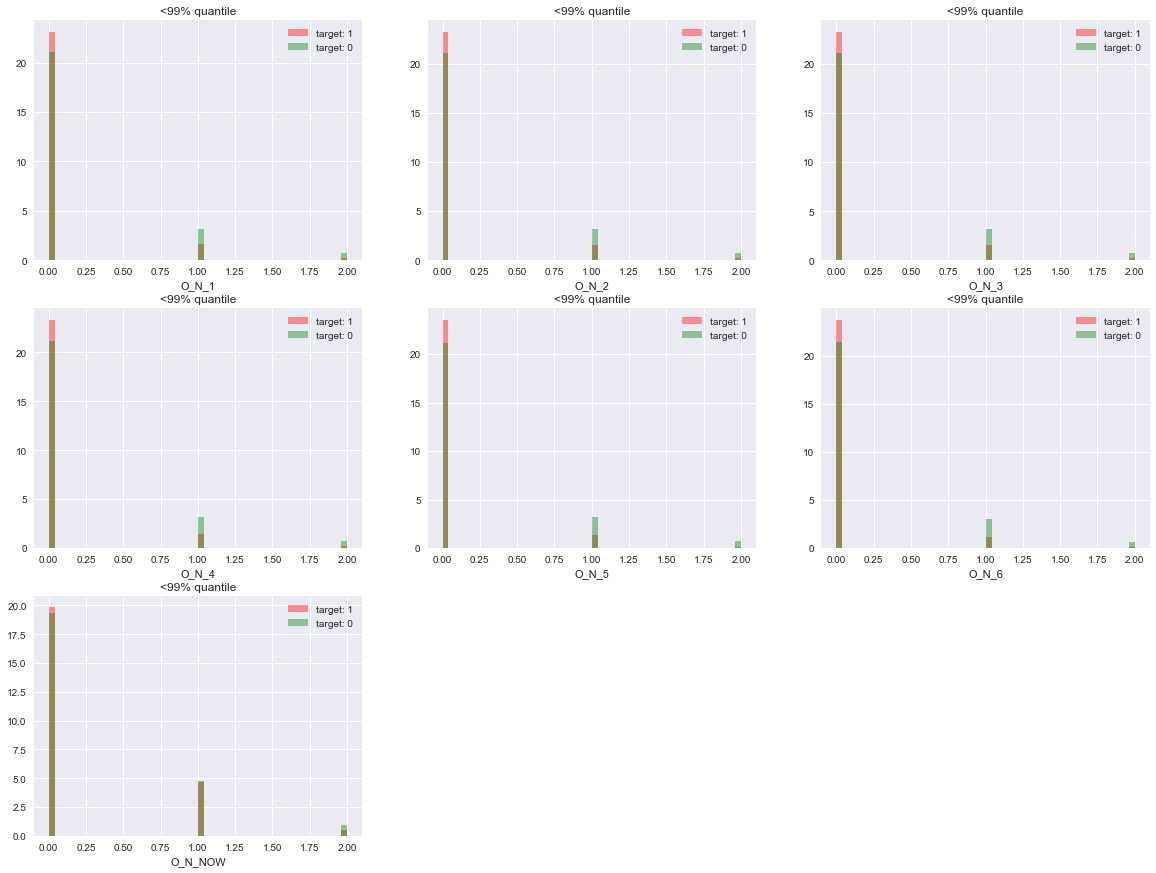

In [33]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7+7+8+7+7,8+8+7+7+8+7+7):
    plt.subplot(3, 3, i-8-7-7-8-7-7)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.99))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.99))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<99% quantile')

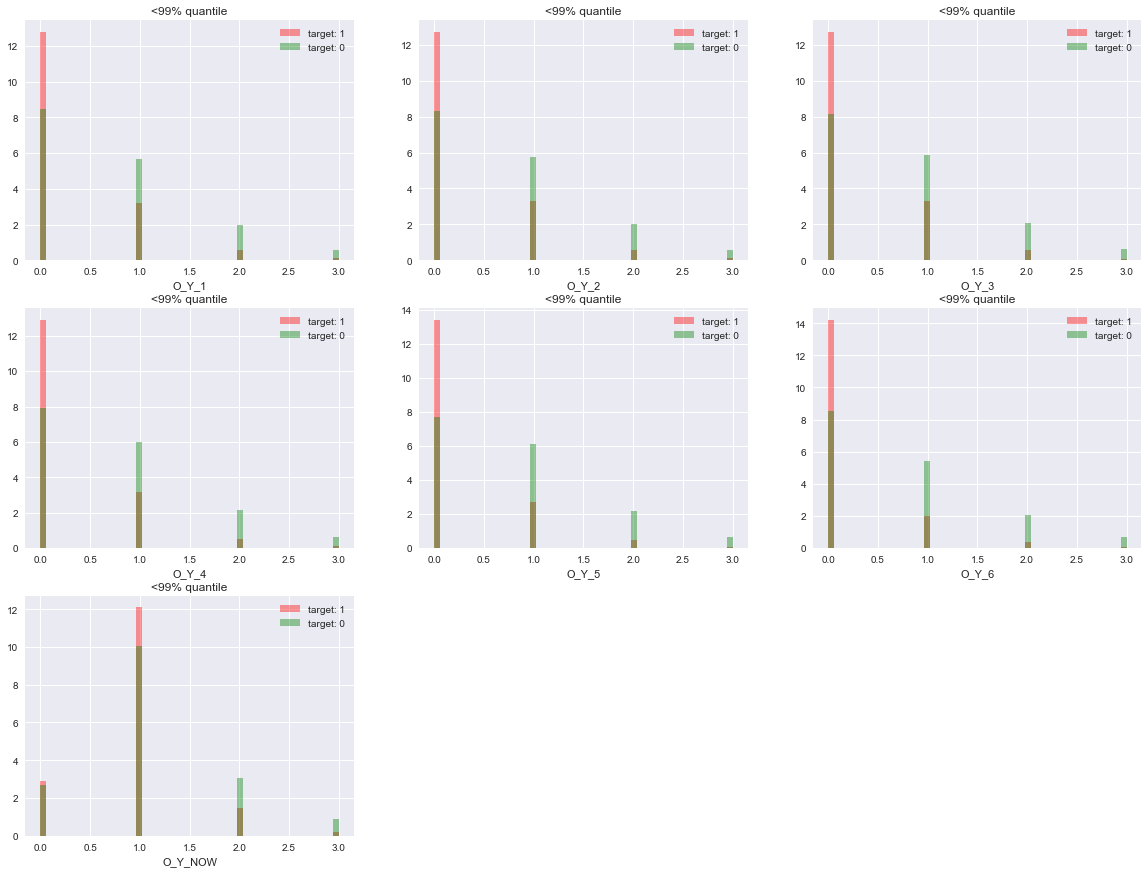

In [34]:
plt.figure(figsize=[20, 15])
for i in range(1+8+7+7+8+7+7+7,8+8+7+7+8+7+7+7):
    plt.subplot(3, 3, i-8-7-7-8-7-7-7)
    sns.distplot(df[(df['target']==1) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.99))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='r',label='target: 1')
    sns.distplot(df[(df['target']==0) & (df.iloc[:,i]<df.iloc[:,i].quantile(0.99))].iloc[:,i].apply(lambda x: 0 if x<0 else x),kde=False,norm_hist=True,color='g',label='target: 0')
    plt.legend()
    plt.title('<99% quantile')

По способу оформления заказа клиенты мало отличаются, все предпочитают - Интернет.

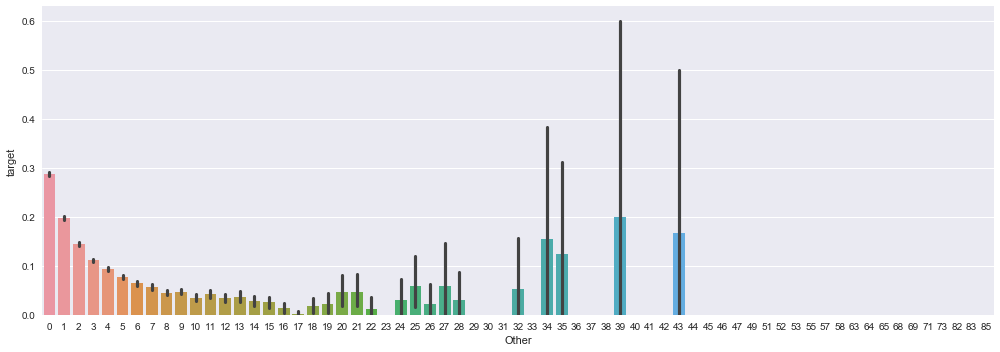

In [35]:
sns.factorplot(x='Other',y='target',data=df,kind='bar',size=5,aspect=2.8);

По распределению доли отточных клиентов, видна обратная зависимость от количества товарных групп (ТГ) из "Другое", чем меньше ТГ - тем больше доля оттока.

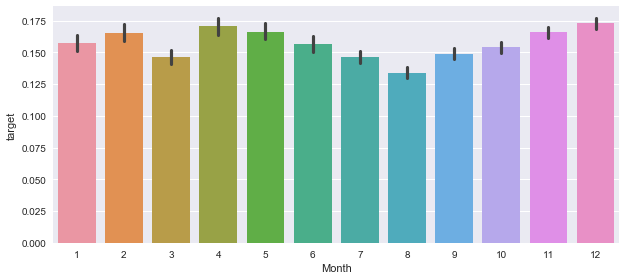

In [36]:
sns.factorplot(x='Month',y='target',data=df,kind='bar',size=4,aspect=2.2);

Доля оттока зависит от рассматриваемого месяца текущей закупки.

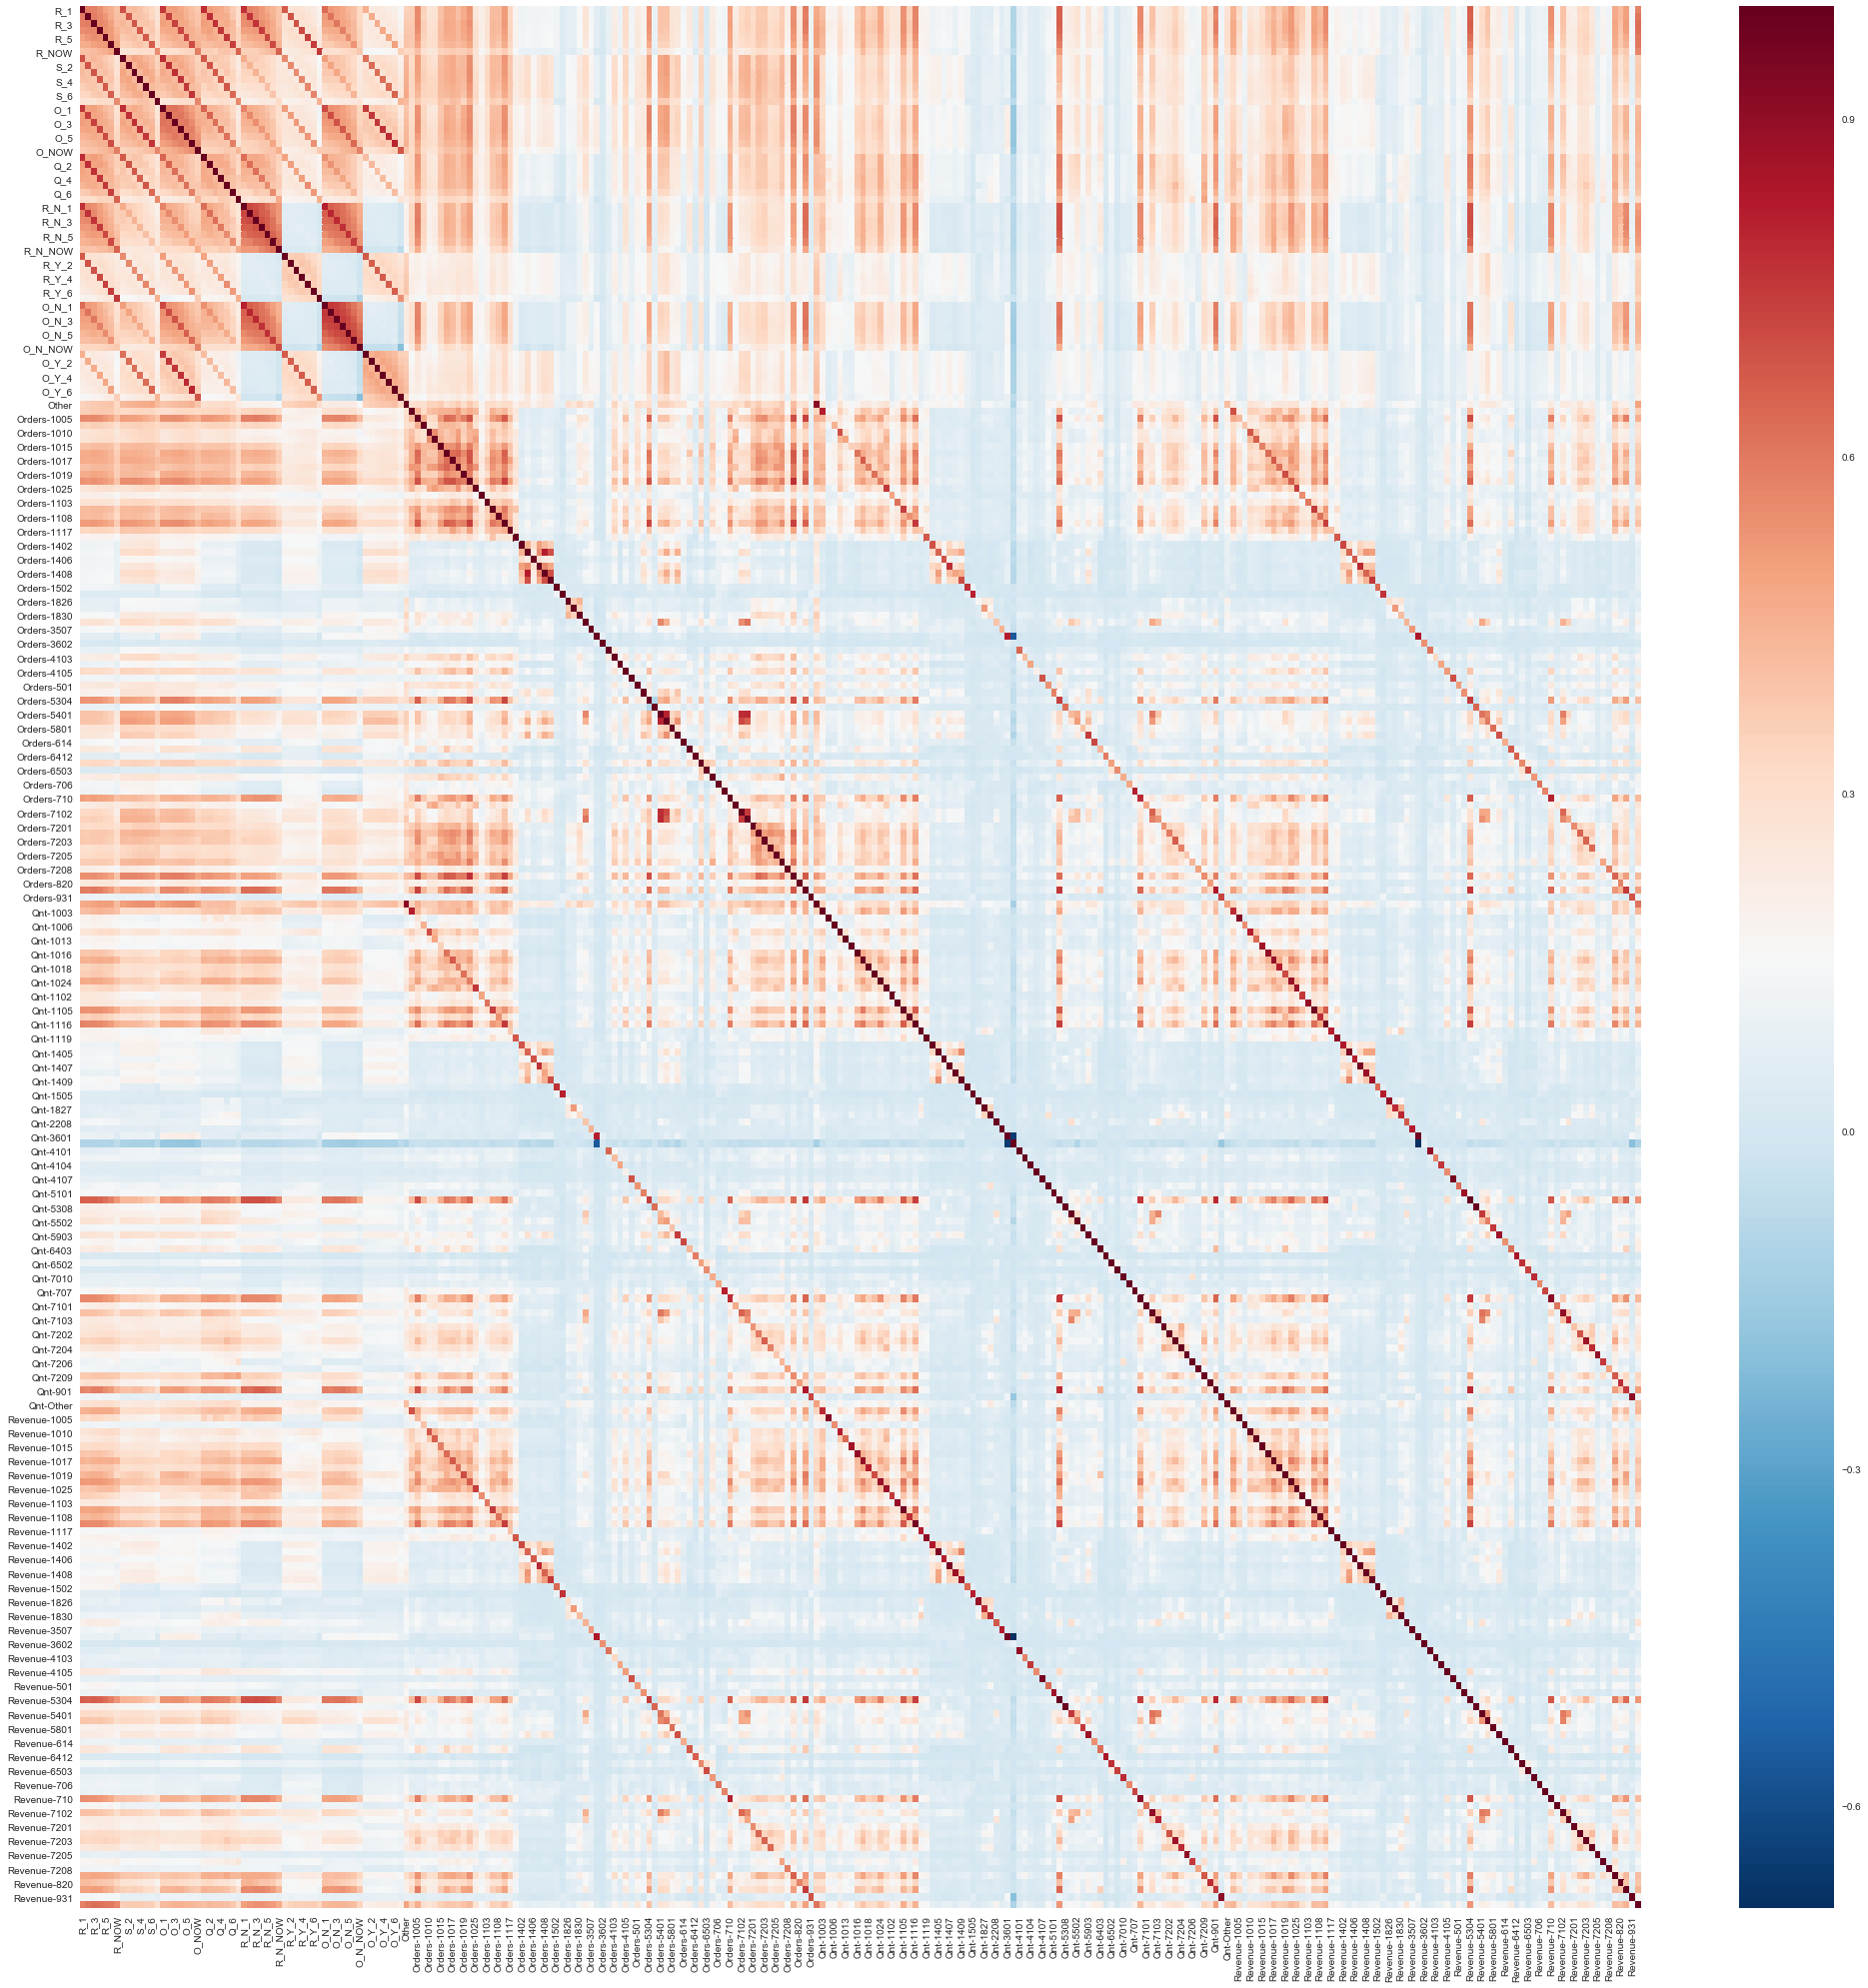

In [37]:
plt.figure(figsize=[35, 35])
sns.heatmap(df.drop(columns=['target','Month']).corr(),cmap="RdBu_r");

Из корреляционной матрицы видно, что есть коррелирующие признаки:
- Заказы, выручка и штуки по товарным группам и по времени;
- Одинаковые признаки по времени;

###  Часть 4. Закономерности, "инсайты", особенности данных.

Найдены и выдвинуты предположения о природе различных корреляций/пропусков/закономерностей и выбросов, найденных в предыдущих пунктах. Есть пояснение, почему они важны для решаемой задачи;

**По проведённому анализу можно сделать выводы:**
- Клиенты, которые не закупятся в ближайшие 3 месяца, реже закупались в предыдущие полгода;
- Данные клиенты покупали меньше товаров из категории "Other";
- Пик распределения суммы отгрузки в момент "NOW" у данных клиентов находится в районе 4000;
- Есть сезонная (по месяцам) зависимость;
- Признаки, связанные со способом оформления заказа малоинформативны;
- Есть корреляции заказов, выручки и штук по товарам, скорее всего эти признаки не повышают качество;
- "Выбросы" - это "VIP" клиенты для компании, а не ошибка в данных.

###  Часть 5. Выбор метрики.

Для задач бинарной классификации обычно используются следующие метрики:

- Доля правильных ответов(Accuracy)
- Полнота(Recall)
- Точность (Precision)
- Среднее гармоническое Recall и Precision (F1-Score)
- LogLoss
- Площадь по ROC-кривой (ROC-AUC)

В данной задаче целевой класс несбалансирован (85%/15%).Также для применения модели в жизни нужно оценивать вероятность того, что клиент не сделает покупку в следующем промежутке времени, чтобы выбрать оптимальный порог принятия решения на кого воздействовать различными способами. Таким образом, наиболее подходящей метрикой является **ROC-AUC**.


###  Часть 6. Выбор модели.

В качестве моделей будут использоваться:

- Логистическую регрессию(LogisticRegression)
- Случайный лес(RandomForestClassifier)
- Градиентный бустинг над деревьями (xgboost, lightgbm)

В принципе, это наиболее часто используемые модели для задач классификаций, где обучающая выборка не очень большая и не сильно разряженная. У каждой модели есть свои плюсы для решаемой задачи:

- Логистическая регрессия хороша тем, что легко можно запустить в production, есть интепритируемость;
- Случайный лес - даёт хорошее качество без настройки гиперпараметров, не склонен к переобучению;
- Градиентный бустинг - возможность получить лучшее качество при настройки гиперпараметров. В данной задаче попробуем две реализации данного типа модели.

###  Часть 7-9. Предобработка данных. Кросс-валидация и настройка гиперпараметров модели.Создание новых признаков и описание этого процесса

Проведена предобработка данных для конкретной модели. При необходимости есть и описано масштабирование признаков, заполнение пропусков, замены строк на числа, OheHotEncoding, обработка выбросов, отбор признаков с описанием используемых для этого методов. Корректно сделано разбиение данных на обучающую и отложенную части;

**Из категориальных кризнаков у нас только месяц, сделаем OHE. Удалим столбец "Month".**

In [60]:
df=pd.concat([df,pd.get_dummies(df['Month'], prefix='M', prefix_sep='_')],axis=1)
df=df.drop(columns='Month')

У нас данные представлены за период июль 2016 - декабрь 2017. Для корректной валидации нужно учитывать временную составляющую. На всякий случай отсортируем данные по столбцу "Y_M" и удалим этот признак.

In [64]:
df=df.sort_values(by='Y_M')
df.head()

,Y_M,R_1,R_2,R_3,R_4,R_5,R_6,R_NOW,target,S_1,...,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12
Client,,,,,,,,,,,,,,,,,,,,,
1000786,2016_07,5550,1712,5550,0,5550,0,26591,0,1,...,0,0,0,0,1,0,0,0,0,0
1001493,2016_07,6562,0,8236,0,5096,0,5396,1,13,...,0,0,0,0,1,0,0,0,0,0
1001643,2016_07,0,4878,7106,5987,6990,8176,8005,0,0,...,0,0,0,0,1,0,0,0,0,0
1001901,2016_07,0,0,16854,0,0,0,31623,1,0,...,0,0,0,0,1,0,0,0,0,0
1002150,2016_07,15293,6134,13933,14702,0,14232,12908,0,19,...,0,0,0,0,1,0,0,0,0,0


In [65]:
df.tail()

,Y_M,R_1,R_2,R_3,R_4,R_5,R_6,R_NOW,target,S_1,...,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12
Client,,,,,,,,,,,,,,,,,,,,,
994163,2017_12,0,10231,14286,0,18448,7340,9413,0,0,...,0,0,0,0,0,0,0,0,0,1
994145,2017_12,975,0,975,975,0,975,975,0,1,...,0,0,0,0,0,0,0,0,0,1
993970,2017_12,0,8099,0,0,14065,0,13333,0,0,...,0,0,0,0,0,0,0,0,0,1
997736,2017_12,9026,5974,750,5454,7906,18352,3947,0,29,...,0,0,0,0,0,0,0,0,0,1
99976,2017_12,0,0,0,3593,0,0,4020,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
df=df.drop(columns='Y_M')

Разобьём всю выборку на обучающую и проверочную в соотношении 9:1. В проверочную часть попадут данные за 2 последних месяца.

In [70]:
idx = int(df.shape[0]*0.9)
df_train = df.iloc[:idx,:]
df_valid = df.iloc[idx:,:]

In [71]:
df.shape,df_train.shape,df_valid.shape

((233978, 283), (210580, 283), (23398, 283))

Как уже говорилиось, у нас есть временная зависимость, поэтому для правильной валидации будем использовать sklearn.TimeSeriesSplit. Сделаем 10 фолдов, чтобы валидироваться на выборке соизмеримой с df_valid.

In [74]:
tscv=TimeSeriesSplit(n_splits=10)

Посмотрим на качество моделей без настроек параметров на исходных признаках, для LogisticRegression сделаем стандартизацию признаков.

In [75]:
X_train = df_train.drop(columns='target')
y_train = df_train['target']

In [82]:
lr = LogisticRegression()
rf = RandomForestClassifier()
lg = lgbmc()
xg = xgbc()
cb = catc()

In [83]:
std = StandardScaler()
lr_pipeline = make_pipeline(std,lr)

In [85]:
%%time
lrcv = cross_val_score(lr_pipeline,X_train,y_train,cv=tscv,scoring='roc_auc')
rfcv = cross_val_score(rf,X_train,y_train,cv=tscv,scoring='roc_auc')
lgcv = cross_val_score(lg,X_train,y_train,cv=tscv,scoring='roc_auc')
xgcv = cross_val_score(xg,X_train,y_train,cv=tscv,scoring='roc_auc')

Wall time: 8min 50s


In [88]:
print ('lr_cv_score',np.mean(lrcv),"+-",np.std(lrcv))
print ('rf_cv_score',np.mean(rfcv),"+-",np.std(rfcv))
print ('lg_cv_score',np.mean(lgcv),"+-",np.std(lgcv))
print ('xg_cv_score',np.mean(xgcv),"+-",np.std(xgcv))

lr_cv_score 0.8359639355862789 +- 0.011250799472598279
rf_cv_score 0.7807086950093585 +- 0.010421287997367764
lg_cv_score 0.8441663763252212 +- 0.010616864642820927
xg_cv_score 0.8446171620354617 +- 0.009323954088441699


На кроссвалидации лучший результат оказался у xgboost, худший - у случайного леса, логистическая регрессия показала результат немного ниже, чем у бустинга.

Попробуем улучшить результат с помощью добавлением новых признаков и убиранием малоинформативных, а также настройкой гиперпараметров.

Создадим признаки: Общее количество заказов за период, количество закупок (в месяцах), количество "топовых" товарных групп за 7 месяцев.

In [97]:
df_train['Orders_total']=df_train.iloc[:,15:22].sum(axis=1)

C:\Users\vnich\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


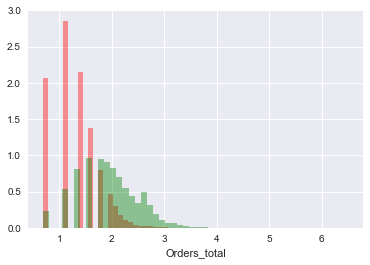

In [100]:
sns.distplot(np.log1p(df_train[df_train['target']==1]['Orders_total'].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='r');
sns.distplot(np.log1p(df_train[df_train['target']==0]['Orders_total'].apply(lambda x: 0 if x<0 else x)),kde=False,norm_hist=True,color='g');

In [107]:
df_train['B_M']=np.array([df_train.iloc[:,i].apply(lambda x: 1 if x >0 else 0) for i in range(0,6)]).sum(axis=0)

C:\Users\vnich\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


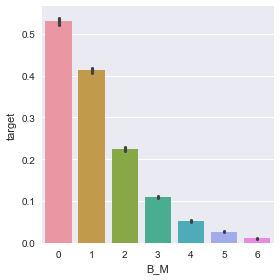

In [108]:
sns.factorplot(y='target',x='B_M',data=df_train,kind='bar');

In [115]:
df_train['TG_total']=np.array([df_train.iloc[:,i].apply(lambda x: 1 if x >0 else 0) for i in range(200,270)]).sum(axis=0)

C:\Users\vnich\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


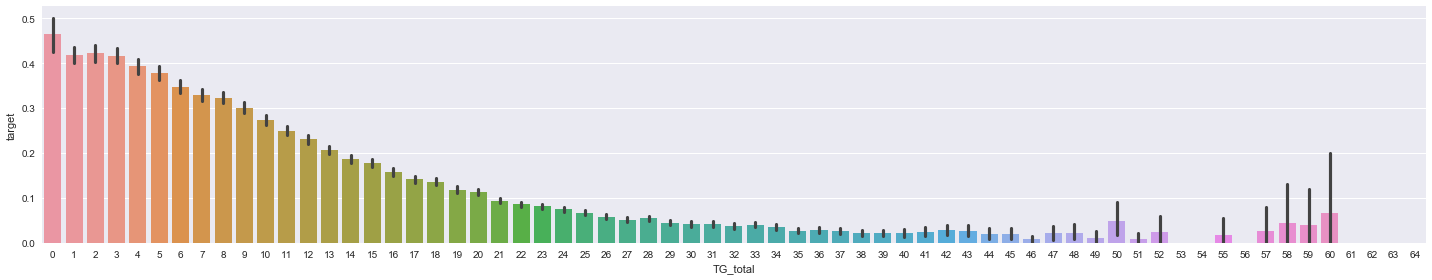

In [116]:
sns.factorplot(y='target',x='TG_total',data=df_train,kind='bar',aspect=5);

По всем трём признакам видна закономерность - чем меньше значение, тем выше доля оттока.
Проверим качество с добавлением этих признаков для xgboost.

In [117]:
X_train = df_train.drop(columns='target')
y_train = df_train['target']

In [118]:
xgcv = cross_val_score(xg,X_train,y_train,cv=tscv,scoring='roc_auc')

In [119]:
print ('xg_cv_score',np.mean(xgcv),"+-",np.std(xgcv))

xg_cv_score 0.8444759280195508 +- 0.009507739811577985


Качество не улучшилось. Настроим параметры на кросс-валидации.

In [142]:
XG_params = {'n_estimators': [100,200,300,400,500],
            'seed':[17],
            'max_depth': [3,4,5,6,7,8],
            'learning_rate': [0.01,0.05,0.1]}

In [146]:
xggs = GridSearchCV(xg,param_grid=XG_params,scoring='roc_auc',cv=tscv)

In [ ]:
xggs.fit(X_train,y_train)

In [123]:
coefs=pd.DataFrame(xg.feature_importances_,X_train.columns,columns=['Importance'])

In [130]:
drop_coef = coefs[coefs['Importance']==0]

In [131]:
dc=list(drop_coef.index)

In [133]:
X_train_new = X_train.drop(columns=dc)

In [134]:
X_train_new.shape

(210580, 133)

In [136]:
xgcv = cross_val_score(xg,X_train_new,y_train,cv=tscv,scoring='roc_auc')

In [137]:
print ('xg_cv_score',np.mean(xgcv),"+-",np.std(xgcv))

xg_cv_score 0.844771346207307 +- 0.009143363076617306


In [185]:
roc_auc_score(y_valid,y_pred_proba)

0.8567000921274363

###  Часть 10. Прогноз для тестовой или отложенной выборки

In [ ]:
xg.fit(X_train,y_train)
y_pred_proba=xg.predict_proba(X_valid)[1]
roc_auc_score(y_valid,y_pred_proba)

### Часть 11. Выводы 

После исследования и построения модели можно сделать следюущие выводы:
    
1)В принципе, получена модель с неплохим качеством, которая может помогать определять клиентов, которые не закупятся в ближайшие 3 месяца.

2)Возможные пути улучшения модели - добавить признаки другого типа (взаимодействия с клиентами), покрутить признаки.

3)Логистическая регрессия показала неплохие результаты, можно попробовать немного поднастроить её вместо построения многих деревьев.
